<a href="https://colab.research.google.com/github/pagliacci0411/LLMs-for-tweets-analisys/blob/main/Anal%C3%ADtica_de_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Índice de Etapas del Código***

1. **Instalación de Librerías:** Se instalan las librerías necesarias para el análisis, incluyendo pandas, numpy, google-cloud-aiplatform, umap-learn, tenacity.

2. **Importación de Librerías:** Se importan las librerías instaladas, junto con otras como re, tqdm, time, plotly.express, sklearn.cluster, matplotlib.pyplot, seaborn, vertexai, google.auth.transport.requests, google.oauth2.service_account, google.generativeai, google.api_core, sklearn.metrics.pairwise, sklearn.manifold, sklearn.cluster, sklearn.metrics, google.colab, collections, pickle.

3. **Credenciales:** Se configuran las credenciales para acceder a Google Cloud Platform y Vertex AI utilizando un archivo de cuenta de servicio.

4. **Importación de Datos:** Se importan los datos de tweets de Davivienda desde un archivo CSV.

5. **Limpieza de Datos:** Se realizan tareas de limpieza de datos, como eliminar columnas innecesarias, renombrar columnas, convertir tipos de datos, manejar valores nulos y limpiar el texto de los tweets.

6. **Análisis Exploratorio de Datos:** Se realiza un análisis exploratorio básico de los datos, incluyendo la visualización de las primeras filas, información del DataFrame, estadísticas descriptivas y la frecuencia de nombres de usuario.

7. **Análisis Exploratorio Basado en Modelo:** Se utiliza un modelo de lenguaje (text-multilingual-embedding-002) para generar embeddings de texto para cada tweet. Se calcula la similitud de coseno entre los embeddings.

8. **Clustering:** Se aplica UMAP para reducir la dimensionalidad de los embeddings y HDBSCAN para realizar clustering basado en densidad. Se visualizan los clusters y se identifica la palabra más común en cada cluster.

9. **Feature Engineering:** Se utiliza snscrape para obtener información adicional de los tweets, como respuestas y conteos de respuestas.

10. **Importación de Modelos:** Se utiliza un modelo de lenguaje (gemini-1.5-pro) para analizar el sentimiento, contexto, grosería, NPS y otros temas de los tweets.

11. **Análisis de Comentarios:** Se procesan las respuestas del modelo de lenguaje, se extrae la información relevante y se


# ***Estrategia***

Se eligio crear esta metodologia de forma muy directa, a diferencia del proyecto de filtros de documentos donde hay muchas arquitecturas posibles, esta para mi fue un camino directo aprovechando los recursos gratuitos de gcp de 300 creditos por 3 meses, y así desarrolar el analisis de tweets.

# ***Librerias***

## ***Instalables***

In [ ]:
# Instala las librerías necesarias
!pip install pandas==2.1.4
!pip install numpy==1.26.4
!pip install google-cloud-aiplatform
!pip install umap-learn
!pip install tenacity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.6 MB/s eta 0:00:00


## ***Importar librerias***

In [ ]:
# Importa las librerías necesarias para el análisis de datos y Machine Learning
import pandas as pd  # Para la manipulación y análisis de datos
import numpy as np  # Para operaciones numéricas
import re  # Para expresiones regulares
from tqdm.auto import tqdm  # Para mostrar barras de progreso
from typing import List, Optional  # Para especificar tipos de datos
import time  # Para trabajar con fechas y tiempos
import umap  # Para la reducción de dimensionalidad
import plotly.express as px  # Para la creación de gráficos interactivos
from sklearn.cluster import HDBSCAN  # Para el clustering basado en densidad


import matplotlib.pyplot as plt  # Para la creación de gráficos
import seaborn as sns  # Para la visualización de datos estadísticos


# Importa librerías para trabajar con Google Cloud Platform y Vertex AI
import vertexai
from google.auth.transport.requests import Request
from google.oauth2.service_account import Credentials
from vertexai.language_models import TextEmbeddingModel
import google.generativeai as genai
from google.api_core import retry
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel




# Importa librerías para el análisis de similitud y clustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Importa librerías para trabajar con Google Colab y otras utilidades
from google.colab import userdata
import time
from tenacity import retry, stop_after_attempt, wait_random_exponential
from collections import Counter
import re
import pickle

# ***Credenciales***

In [ ]:
# Crea un objeto de credenciales para acceder a Google Cloud Platform
credentials = Credentials.from_service_account_file(
    userdata.get('key_path'),
    scopes=['https://www.googleapis.com/auth/cloud-platform'])


# Refresca las credenciales si han expirado
if credentials.expired:
    credentials.refresh(Request())

In [ ]:
# Define el ID del proyecto y la región
PROJECT_ID = userdata.get('PROJECT_ID')
REGION = 'us-central1'


In [ ]:
# Inicializa Vertex AI
vertexai.init(project = PROJECT_ID, location = REGION, credentials = credentials)

In [ ]:
# Configura Google Generative AI
genai.configure(api_key=userdata.get('API_KEY'))

# ***Importar datos***

In [11]:
# Importa los datos de los Tweets de Davivienda desde un archivo CSV
Tweets = pd.read_csv('/content/drive/MyDrive/Notebooks/Concurso analítica no estructurada/Analisis de Tweets/Tweets/davivienda_tweets.csv')

# ***Limpieza de datos***

In [ ]:
# Muestra las primeras filas del DataFrame
Tweets.head()

,Unnamed: 0,UserScreenName,UserName,Timestamp,Text,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL
0,0,Andrés Langebaek,@ALangebaek,2021-12-01T20:43:12.000Z,Andrés Langebaek\n@ALangebaek\n·\n1 dic.,La confianza se afectó. El indicador de confia...,NaN,1.0,7,19,['https://pbs.twimg.com/media/FFjL57eXMAISBnk?...,https://twitter.com/ALangebaek/status/14661458...
1,1,Plaza Futura,@plaza_futura,2021-12-01T21:18:10.000Z,Plaza Futura\n@plaza_futura\n·\n1 dic.,Buscamos la accesibilidad y mejor atención en ...,✅ ✅ ✅ ✅ ✅,NaN,NaN,NaN,['https://pbs.twimg.com/ext_tw_video_thumb/146...,https://twitter.com/plaza_futura/status/146615...
2,2,Julián Martinez,@JulianM998,2021-12-01T22:49:11.000Z,Julián Martinez\n@JulianM998\n·\n1 dic.,Señores \n@Davivienda\n no he podido ingresar ...,NaN,1.0,NaN,1,[],https://twitter.com/JulianM998/status/14661775...
3,3,Ferchis.,@fergomezr28,2021-12-01T12:29:07.000Z,Ferchis.\n@fergomezr28\n·\n1 dic.,Llevo toda una semana sufriendo intento de hur...,NaN,2.0,1,2,[],https://twitter.com/fergomezr28/status/1466021...
4,4,MirandaL2,@MirandaSuspLo,2021-12-01T20:52:36.000Z,MirandaL2\n@MirandaSuspLo\n·\n1 dic.,Hemos retrocedido tanto en este país con este ...,NaN,3.0,NaN,8,[],https://twitter.com/MirandaSuspLo/status/14661...


In [ ]:
# Muestra información sobre el DataFrame, incluyendo tipos de datos y valores no nulos
Tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1811 entries, 0 to 1810
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      1811 non-null   int64  
 1   UserScreenName  1807 non-null   object 
 2   UserName        1811 non-null   object 
 3   Timestamp       1811 non-null   object 
 4   Text            1811 non-null   object 
 5   Embedded_text   1811 non-null   object 
 6   Emojis          295 non-null    object 
 7   Comments        838 non-null    float64
 8   Likes           247 non-null    object 
 9   Retweets        643 non-null    object 
 10  Image link      1811 non-null   object 
 11  Tweet URL       1811 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 169.9+ KB


In [ ]:
# Elimina columnas innecesarias
Tweets = Tweets.drop(axis=1,columns=['Unnamed: 0','Text'])
# Renombra la columna de fecha
Tweets = Tweets.rename(columns={Tweets.columns[2]: 'Fecha'})
# Convierte la columna de fecha al tipo de dato datetime
Tweets['Fecha'] = pd.to_datetime(Tweets['Fecha'])

# Define una función para convertir strings a números (maneja casos como "1.2k" o "1.5mil")
import numpy as np
def convert_to_float(value):
  if isinstance(value, str):
    value = value.lower().replace(',', '')
    if 'mil' in value:
      value = float(value.replace('mil', '')) * 1000
    elif 'k' in value:
      value = float(value.replace('k', '')) * 1000
    else:
      try:
        value = float(value)
      except ValueError:
        value = np.nan
  return value

# Aplica la función a las columnas de 'Likes' y 'Retweets'
Tweets['Likes'] = Tweets['Likes'].apply(convert_to_float)
Tweets['Retweets'] = Tweets['Retweets'].apply(convert_to_float)

In [ ]:
# Muestra las primeras filas del DataFrame después de la limpieza
Tweets.head()

,UserScreenName,UserName,Fecha,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL
0,Andrés Langebaek,@ALangebaek,2021-12-01 20:43:12+00:00,La confianza se afectó. El indicador de confia...,NaN,1.0,7.0,19.0,['https://pbs.twimg.com/media/FFjL57eXMAISBnk?...,https://twitter.com/ALangebaek/status/14661458...
1,Plaza Futura,@plaza_futura,2021-12-01 21:18:10+00:00,Buscamos la accesibilidad y mejor atención en ...,✅ ✅ ✅ ✅ ✅,NaN,NaN,NaN,['https://pbs.twimg.com/ext_tw_video_thumb/146...,https://twitter.com/plaza_futura/status/146615...
2,Julián Martinez,@JulianM998,2021-12-01 22:49:11+00:00,Señores \n@Davivienda\n no he podido ingresar ...,NaN,1.0,NaN,1.0,[],https://twitter.com/JulianM998/status/14661775...
3,Ferchis.,@fergomezr28,2021-12-01 12:29:07+00:00,Llevo toda una semana sufriendo intento de hur...,NaN,2.0,1.0,2.0,[],https://twitter.com/fergomezr28/status/1466021...
4,MirandaL2,@MirandaSuspLo,2021-12-01 20:52:36+00:00,Hemos retrocedido tanto en este país con este ...,NaN,3.0,NaN,8.0,[],https://twitter.com/MirandaSuspLo/status/14661...


In [ ]:
# Muestra la cantidad de valores nulos en cada columna
Tweets.isna().sum()

,0
UserScreenName,4
UserName,0
Fecha,0
Embedded_text,0
Emojis,1516
Comments,973
Likes,1564
Retweets,1168
Image link,0
Tweet URL,0


In [ ]:
# Reemplaza los valores nulos en la columna 'UserScreenName' con 'Sin Nombre'
Tweets.UserScreenName[Tweets.UserScreenName.isna()] = 'Sin Nombre'

<ipython-input-110-469e1b4dff02>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Muestra los primeros 6 valores de la columna 'Embedded_text'
Tweets.Embedded_text.head(6).values

array(['La confianza se afectó. El indicador de confianza Davivienda tuvo una  leve caída en noviembre, rompiendo una tendencia de cinco meses de mejoras. El indicador se deterioró, especialmente en la última semana del mes, asociado al aumento en la tasa de cambio.\n1\n7\n19',
       'Buscamos la accesibilidad y mejor atención en tus trámites bancarios, es por ello que encuentras en nuestra plaza los siguientes bancos para tu preferencia.\n Banco Cuscatlán\n Banco Fedecrédito\n Davivienda\n Bancoagrícola\n Banco Promerica',
       'Señores \n@Davivienda\n no he podido ingresar a mi app davivienda, ingreso la cédula y me dice verifique los datos, llevo así varios días.\n1\n1',
       'Llevo toda una semana sufriendo intento de hurto por medios electrónicos a mi cuenta de ahorros \n@Davivienda\n, sin que se puedan realizar porque no tengo plata. No felices, lo hicieron con la TC y con esta sí pudieron ya que tenía cupo libre. ¿Qué está pasando \n@Davivienda\n?\n2\n1\n2',
       'Hemos r

In [ ]:
# Muestra los últimos 6 valores de la columna 'Embedded_text'
Tweets.Embedded_text.tail(6).values

array(['En respuesta a \n@labduls\nBuenas tardes. Lamentamos este tipo de inconvenientes. Por favor escribanos por mensaje privado para validar su caso. Quedamos atentos.\n3',
       'En respuesta a \n@JaimeMolina\nBuenas tardes. Sr. Jaime, en este momento nuestros canales de atención están funcionando con normalidad. Por lo que para validar su caso en detalle lo invitamos a escribir por mensaje privado. Quedamos atentos.\n1',
       'En respuesta a \n@josefe71\nHola Jose , gracias por escribirnos. Trabajamos cada día para mejorar su experiencia. Nos interesa conocer en detalle lo ocurrido, por favor amplíenos los detalles del caso y confírmenos sus datos por mensaje interno, para brindar pronta asistencia. Quedamos atentos.\n1',
       'En respuesta a \n@gleniiaaa\nHola! Bienvenida a nuestro canal de atención, soy Karen y la acompañaré a resolver su solicitud. Por favor envíenos por mensaje interno su número de identificación y con gusto lo resolveremos. Feliz día.',
       'En respue

In [ ]:
# Limpia la columna 'Embedded_text' eliminando respuestas, hilos y caracteres especiales
Tweets['Embedded_text'] = Tweets['Embedded_text'].str.replace(r'^En respuesta a \n@.*\n', '(Respuesta) ', regex=True)
Tweets['Embedded_text'] = Tweets.UserScreenName + ': ' + Tweets.Embedded_text
Tweets['Embedded_text'] = Tweets['Embedded_text'].str.replace(r'\n\d+\n\d+\n\d+', '', regex=True)
Tweets['Embedded_text'] = Tweets['Embedded_text'].str.replace(r'\n\d+\n\d+', '', regex=True)
Tweets['Embedded_text'] = Tweets['Embedded_text'].str.replace(r'\n\d', '', regex=True)
Tweets['Embedded_text'] = Tweets['Embedded_text'].str.replace(r'\nMostrar este hilo', '', regex=True)
Tweets['Embedded_text'] = Tweets['Embedded_text'].str.replace(r'\n', ' ', regex=True)

In [ ]:
# Muestra los primeros 6 valores de la columna 'Embedded_text' después de la limpieza
Tweets.Embedded_text.head(6).values

array(['Andrés Langebaek: La confianza se afectó. El indicador de confianza Davivienda tuvo una  leve caída en noviembre, rompiendo una tendencia de cinco meses de mejoras. El indicador se deterioró, especialmente en la última semana del mes, asociado al aumento en la tasa de cambio.',
       'Plaza Futura: Buscamos la accesibilidad y mejor atención en tus trámites bancarios, es por ello que encuentras en nuestra plaza los siguientes bancos para tu preferencia.  Banco Cuscatlán  Banco Fedecrédito  Davivienda  Bancoagrícola  Banco Promerica',
       'Julián Martinez: Señores  @Davivienda  no he podido ingresar a mi app davivienda, ingreso la cédula y me dice verifique los datos, llevo así varios días.',
       'Ferchis.: Llevo toda una semana sufriendo intento de hurto por medios electrónicos a mi cuenta de ahorros  @Davivienda , sin que se puedan realizar porque no tengo plata. No felices, lo hicieron con la TC y con esta sí pudieron ya que tenía cupo libre. ¿Qué está pasando  @Davivie

In [ ]:
# Muestra los últimos 6 valores de la columna 'Embedded_text' después de la limpieza
Tweets.Embedded_text.tail(6).values

array(['Banco Davivienda: (Respuesta) Buenas tardes. Lamentamos este tipo de inconvenientes. Por favor escribanos por mensaje privado para validar su caso. Quedamos atentos.',
       'Banco Davivienda: (Respuesta) Buenas tardes. Sr. Jaime, en este momento nuestros canales de atención están funcionando con normalidad. Por lo que para validar su caso en detalle lo invitamos a escribir por mensaje privado. Quedamos atentos.',
       'Banco Davivienda: (Respuesta) Hola Jose , gracias por escribirnos. Trabajamos cada día para mejorar su experiencia. Nos interesa conocer en detalle lo ocurrido, por favor amplíenos los detalles del caso y confírmenos sus datos por mensaje interno, para brindar pronta asistencia. Quedamos atentos.',
       'Banco Davivienda: (Respuesta) Hola! Bienvenida a nuestro canal de atención, soy Karen y la acompañaré a resolver su solicitud. Por favor envíenos por mensaje interno su número de identificación y con gusto lo resolveremos. Feliz día.',
       'Banco Davivie

# ***Analisis exploratorio de Datos***

En esta seccion se explora los datos y se descubre que no estan las conversaciones completas, lo que puede incrruir en problemas de analisis.

In [ ]:
# Busca tweets que contengan la palabra '@diegoruix'
Tweets[Tweets.Embedded_text.str.contains('@diegoruix', case=False) ]

,UserScreenName,UserName,Fecha,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL


In [ ]:
# Busca tweets del usuario '@diegoruix'
Tweets[Tweets.UserName == '@diegoruix']

,UserScreenName,UserName,Fecha,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL


In [ ]:
# Muestra las últimas 6 URLs de tweets
Tweets['Tweet URL'].tail(6).values

array(['https://twitter.com/Davivienda/status/1473761261062356993',
       'https://twitter.com/Davivienda/status/1473721660612218894',
       'https://twitter.com/Davivienda/status/1473749850860650496',
       'https://twitter.com/Davivienda/status/1473713636749320195',
       'https://twitter.com/Davivienda/status/1473620639546183680',
       'https://twitter.com/Davivienda/status/1473452462493540353'],
      dtype=object)

In [ ]:
# Muestra estadísticas descriptivas del DataFrame
Tweets.describe(include='all')

,UserScreenName,UserName,Fecha,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL
count,1811,1811,1811,1811,295,838.000000,247.000000,643.000000,1811,1811
unique,1144,1168,NaN,1771,212,NaN,NaN,NaN,203,1811
top,Banco Davivienda,@Davivienda,NaN,Banco Davivienda: (Respuesta) Buenos días. Lam...,😡,NaN,NaN,NaN,[],https://twitter.com/ALangebaek/status/14661458...
freq,245,245,NaN,7,9,NaN,NaN,NaN,1594,1
mean,NaN,NaN,2021-12-14 04:41:07.457757952+00:00,NaN,NaN,1.511933,68.137652,45.667185,NaN,NaN
min,NaN,NaN,2021-12-01 00:01:49+00:00,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN
25%,NaN,NaN,2021-12-09 17:57:21.500000+00:00,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN
50%,NaN,NaN,2021-12-15 21:13:27+00:00,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN
75%,NaN,NaN,2021-12-18 04:53:41+00:00,NaN,NaN,1.000000,2.000000,3.000000,NaN,NaN
max,NaN,NaN,2021-12-22 23:53:50+00:00,NaN,NaN,87.000000,15000.000000,25000.000000,NaN,NaN


In [ ]:
# Muestra la frecuencia de cada nombre de usuario
Tweets.UserScreenName.value_counts()

,count
UserScreenName,
Banco Davivienda,245
Carlos Eduardo Noguera,41
Davivienda Corredores,23
Edison Mejia,9
Juan. Manuel,8
...,...
Amaranta Ursula,1
AngelaCabasB!,1
Carlos Gutiérrez,1


# ***Analisis exploratorio de Dato basado en modelo***

## **Comentarios**

Una de las alternativas fue elegir los modelos con puntaje mas alto en el [Leaderboar](https://huggingface.co/spaces/mteb/leaderboard) de HF, pero dado que no se tenian los suficientes recursos computaciones para correrlos localmente finalmente se activo la prueba gratuita de GCP y vertex AI





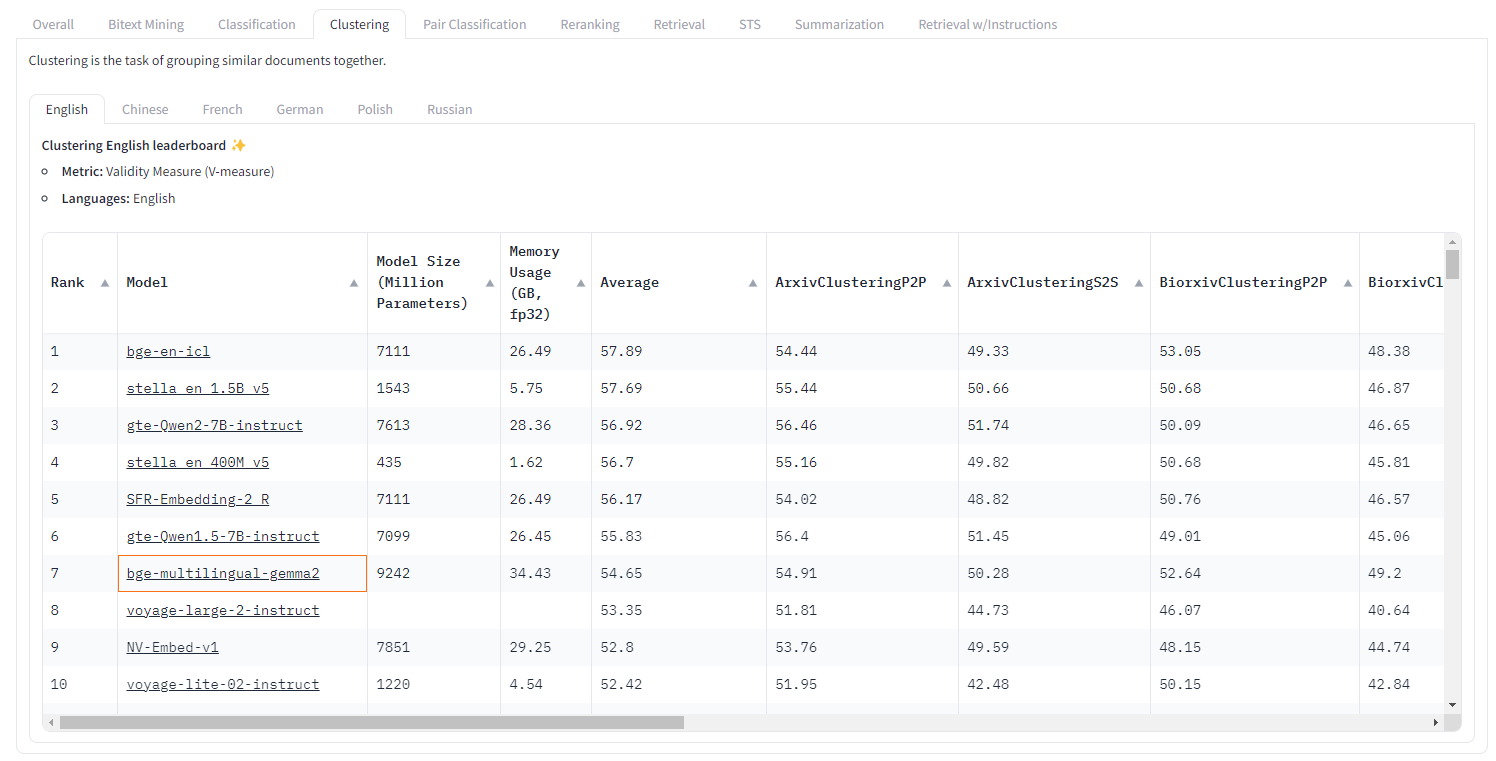

Prueba gratuida de GCP 300 creditos por 3 meses

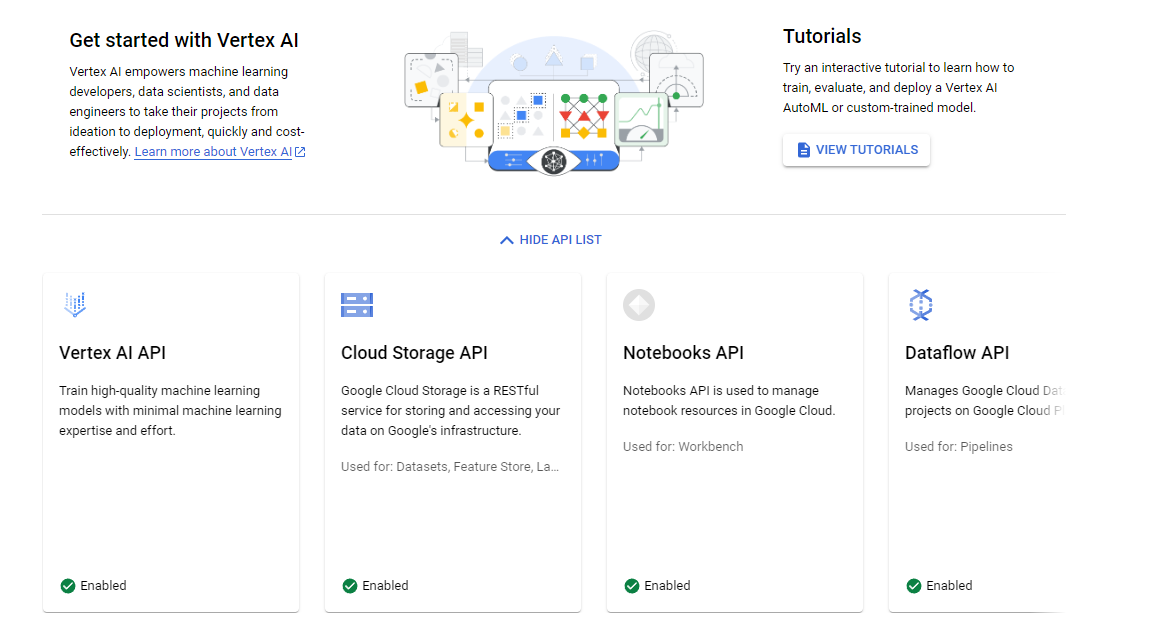

Ativar plan de 300 usd 90 dias

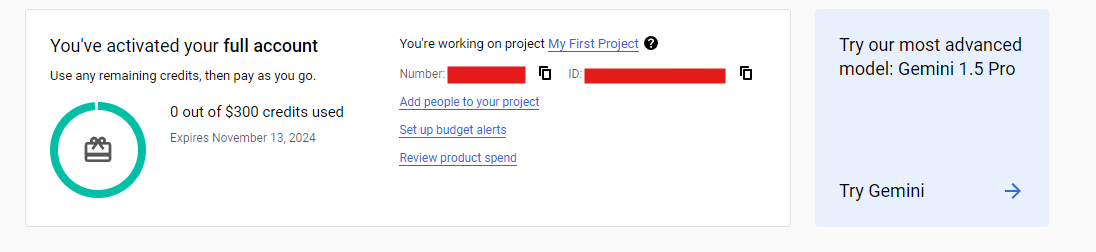

Activacione de claves de Google AI Studio para la API de gemini

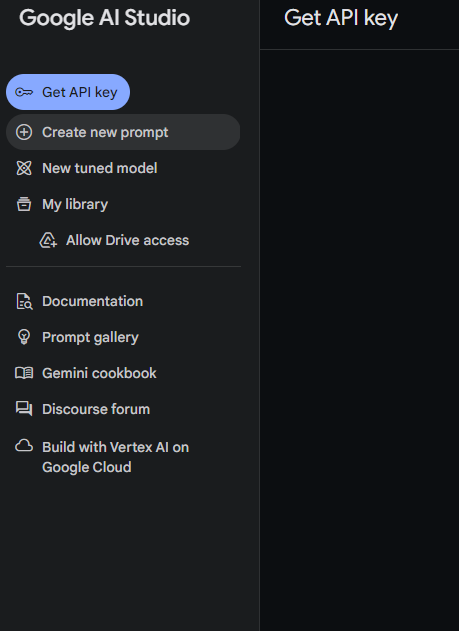

## Desarrollo

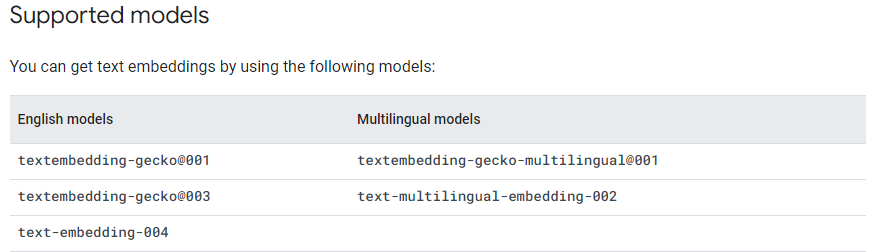

In [ ]:
# Habilita la función progress_apply para Pandas
tqdm.pandas()
# Define una función para generar embeddings de texto usando el modelo de Google Generative AI
def make_embed_text_fn(model):
  @retry.Retry(timeout=300.0)
  def embed_fn(text: str) -> list[float]:
    # Set the task_type to CLUSTERING.
    embedding = genai.embed_content(model=model,
                                    content=text,
                                    task_type="clustering")
    return embedding["embedding"]
  return embed_fn

# Define una función para crear embeddings para un DataFrame
def create_embeddings(df):
  model = 'models/text-multilingual-embedding-002'
  df['Embeddings'] = df['Embedded_text'].progress_apply(make_embed_text_fn(model))
  return df

In [ ]:
# Define una función para generar embeddings de texto usando el modelo de Vertex AI
def embed_text(
    texts: List[str] = ["Muy mal servicio que presta el banco", "Gracias por todo son excelentes", "Voy a retirar mis productos de banco, la poagina web nunca funciona"],
    task: str = "CLUSTERING",
    model_name: str = "text-multilingual-embedding-002",
    dimensionality: Optional[int] = 768,
) -> List[List[float]]:
    """Embeds texts with a pre-trained, foundational model."""
    model = TextEmbeddingModel.from_pretrained(model_name)
    inputs = [TextEmbeddingInput(text, task) for text in texts]
    kwargs = dict(output_dimensionality=dimensionality) if dimensionality else {}
    embeddings = model.get_embeddings(inputs, **kwargs)
    return [embedding.values for embedding in embeddings]

In [ ]:
# Genera embeddings para un ejemplo de textos
aux = embed_text()

In [ ]:
# Muestra la longitud de los embeddings generados
len(aux)

3

In [ ]:
# Calcula la similitud de coseno entre los embeddings
print(cosine_similarity(aux_reshaped[0].reshape(1,-1), aux_reshaped[1].reshape(1,-1)))
print(cosine_similarity(aux_reshaped[1].reshape(1,-1), aux_reshaped[2].reshape(1,-1)))
print(cosine_similarity(aux_reshaped[0].reshape(1,-1), aux_reshaped[2].reshape(1,-1)))

[[0.59289236]]
[[0.52491928]]
[[0.79070981]]


Vemos que los embeddings funcionan bien al tener la mayor cercania entre las palabras con significado más cercano.

Palabras :
```
["Muy mal servicio que presta el banco", "Gracias por todo son excelentes", "Voy a retirar mis productos de banco, la poagina web nunca funciona"]
```



In [ ]:
# Crea un DataFrame vacío para almacenar los embeddings
embeddings = pd.DataFrame()
# Define el tamaño de cada chunk
chunk_size = 250


# Obtiene el número total de filas en el DataFrame
total_rows = Tweets.shape[0]
i = 0

# Itera sobre el DataFrame en chunks de 250 filas
for start_row in tqdm(range(0, total_rows, chunk_size)):
    # Define la fila final, asegurándose de que no exceda el número total de filas
    end_row = min(start_row + chunk_size, total_rows)

    # Extrae el chunk del DataFrame
    aux = pd.DataFrame(embed_text(texts = Tweets.Embedded_text.iloc[start_row:end_row].values[0:250]))
    embeddings = pd.concat([embeddings, aux], axis=0)


  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
# Concatena los embeddings al DataFrame original
Tweets = pd.concat([Tweets, embeddings.reset_index()], axis=1)

In [ ]:
# Elimina la columna 'index'
Tweets.drop(columns=['index'], inplace=True)

# Guarda el DataFrame con los embeddings en un archivo CSV
Tweets.to_csv('/content/drive/MyDrive/Notebooks/Concurso analítica no estructurada/Analisis de Tweets/Tweetsyembeddings.csv', index=False)

## Cluster

In [ ]:
T# Carga el DataFrame con los embeddings desde un archivo CSV
Tweets = pd.read_csv('/content/drive/MyDrive/Notebooks/Concurso analítica no estructurada/Analisis de Tweets/Tweetsyembeddings.csv')

In [ ]:
# Aplica UMAP para reducir la dimensionalidad de los embeddings
reducer = umap.UMAP(n_components= 2, transform_seed=42,  min_dist=0.2,  n_neighbors=15 )
embedding_UMAP = reducer.fit_transform(Tweets[Tweets.columns[-768:]])

In [ ]:
# Agrega las columnas de UMAP al DataFrame
Tweets['embedding_UMAP1'] = embedding_UMAP[:, 0]
Tweets['embedding_UMAP2'] = embedding_UMAP[:, 1]

In [ ]:
# Aplica HDBSCAN para el clustering
hdb = HDBSCAN(min_cluster_size=40, min_samples = 1)
hdb.fit(embedding_UMAP)
Tweets['HDBSCAN_Cluster'] = hdb.labels_

In [ ]:
# Muestra la cantidad de tweets en cada cluster
Tweets.HDBSCAN_Cluster.value_counts()

,count
HDBSCAN_Cluster,
2,351
7,148
12,134
3,111
15,108
6,103
9,101
17,95
10,91


In [ ]:
# Crea un gráfico de dispersión de los clusters usando Plotly Express
fig = px.scatter( Tweets, x = 'embedding_UMAP1', y = 'embedding_UMAP2',  color = hdb.labels_ )
fig.show()

In [ ]:
# Crea un DataFrame auxiliar con el texto y el cluster
aux_df = Tweets[['Embedded_text','HDBSCAN_Cluster']]


# Define una lista de stopwords (palabras comunes que se ignorarán)
stopwords = ['de', 'por', 'la', 'de', 'y', 'que', 'a', 'su', 'lo','que','davivienda',
             'para','más','los','no','el','con','en','me','respuesta','es','un','como',
             'mi','del','se','las','está','una','q','ya','le']


# Define una función para limpiar y tokenizar el texto
def clean_text(text):
    # Convierte el texto a minúsculas
    text = text.lower()
    # Elimina la puntuación y los números
    text = re.sub(r'[^\w\s]', '', text)
    # Divide el texto en palabras
    words = text.split()
    # Elimina las stopwords
    words = [word for word in words if word not in stopwords]
    return words


# Agrupa por cluster y concatena los comentarios
cluster_word_counts = {}


for cluster, group in aux_df.groupby('HDBSCAN_Cluster'):
    # Concatena todos los comentarios en el cluster
    all_comments = " ".join(group['Embedded_text'])
    # Limpia y tokeniza el texto concatenado
    words = clean_text(all_comments)
    # Cuenta la frecuencia de las palabras
    word_counts = Counter(words)
    # Almacena la palabra más común en el cluster
    most_common_word = word_counts.most_common(1)[0]  # Returns a tuple (word, count)
    cluster_word_counts[cluster] = most_common_word


# Muestra la palabra más común para cada cluster
for cluster, (word, count) in cluster_word_counts.items():
    print(f"Cluster {cluster}: Most common word is '{word}' with {count} occurrences.")

Cluster -1: Most common word is 'caso' with 32 occurrences.
Cluster 0: Most common word is 'mensaje' with 51 occurrences.
Cluster 1: Most common word is 'servicio' with 25 occurrences.
Cluster 2: Most common word is 'lugar' with 53 occurrences.
Cluster 3: Most common word is 'app' with 63 occurrences.
Cluster 4: Most common word is 'daviplata' with 51 occurrences.
Cluster 5: Most common word is 'banco' with 40 occurrences.
Cluster 6: Most common word is 'dinero' with 62 occurrences.
Cluster 7: Most common word is 'bancolombia' with 74 occurrences.
Cluster 8: Most common word is 'cuenta' with 16 occurrences.
Cluster 9: Most common word is 'están' with 21 occurrences.
Cluster 10: Most common word is 'banco' with 77 occurrences.
Cluster 11: Most common word is 'binance' with 27 occurrences.
Cluster 12: Most common word is 'cuenta' with 33 occurrences.
Cluster 13: Most common word is 'wilsonariasc' with 36 occurrences.
Cluster 14: Most common word is 'cajeros' with 25 occurrences.
Cluster 

In [ ]:
# Guarda el modelo UMAP en un archivo pickle
filename = '/content/drive/MyDrive/Notebooks/Concurso analítica no estructurada/Analisis de Tweets/reducer.pkl'
pickle.dump(reducer, open(filename, 'wb'))

In [ ]:
# Guarda los tweets con la información del cluster en un archivo CSV
Tweets.to_csv('/content/drive/MyDrive/Notebooks/Concurso analítica no estructurada/Analisis de Tweets/Tweets_con_cluster.csv', index=False)

# ***feature engineering***

In [ ]:
# Instala la librería snscrape
!pip install snscrape
import snscrape.modules.twitter as sntwitter


# Define la URL de un tweet
tweet_url = 'https://twitter.com/Davivienda/status/1473761261062356993'

# Extrae el ID del tweet
tweet_id = tweet_url.split('/')[-1]
tweet_id

# Define una consulta para buscar respuestas al tweet
query = f"conversation_id:{tweet_id} lang:es"
query

# Busca la primera respuesta al tweet
for tweet in sntwitter.TwitterSearchScraper(query).get_items():
  break


# Define el ID del tweet
tweet_id = tweet_url.split('/')[-1]

# Define una consulta para buscar respuestas al tweet
query = f"conversation_id:{tweet_id} lang:es"


# Crea una lista para almacenar las respuestas
replies = []


# Busca todas las respuestas al tweet
for tweet in sntwitter.TwitterSearchScraper(query).get_items():
  replies.append([tweet.date, tweet.id, tweet.content, tweet.username, tweet.inReplyToTweetId])


# Define una función para buscar respuestas a un tweet
def scrape_tweet_replies(tweet_url):
    # Extrae el ID del tweet
    tweet_id = tweet_url.split('/')[-1]

    # Define una consulta para buscar respuestas al tweet
    query = f"conversation_id:{tweet_id} lang:es"


    # Crea una lista para almacenar las respuestas
    replies = []


    # Busca todas las respuestas al tweet
    for tweet in sntwitter.TwitterSearchScraper(query).get_items():
        replies.append([tweet.date, tweet.id, tweet.content, tweet.username, tweet.inReplyToTweetId])


    # Crea un DataFrame con las respuestas
    df = pd.DataFrame(replies, columns=['Date', 'Tweet_ID', 'Content', 'Username', 'InReplyToTweetId'])
    return df


# Busca las respuestas a un tweet específico
tweet_url = 'https://x.com/Davivienda/status/1473452462493540353'
df_replies = scrape_tweet_replies(tweet_url)
print(df_replies)


# Define una lista de IDs de tweets
tweet_ids = [16253717352, 22245152650, 1073767381732864000, 1066986547277414400]

# Itera sobre los IDs de tweets y busca información sobre cada tweet
for id in tweet_ids:
  scraper = sntwitter.TwitterTweetScraper(id).get_items()
  try:
    for tweet in scraper:
      tweet_df = {'text': tweet.rawContent, 'reply_count': tweet.replyCount}
      tweet_df = pd.Dataframe.from_records([tweet_df])
  except KeyError:
    print(f'tweet with id: {id} was not found' )

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 2.9 MB/s eta 0:00:00


# ***Importar modelos***

Nelly Restrepo: @Davivienda  sigue siendo el peor banco!!!!  relegar las transacciones a un espacio de 2X2 es el colmo para todo tipo de trámite
```
{
  "comentario": "Nelly Restrepo: @Davivienda  sigue siendo el peor banco!!!!  relegar las transacciones a un espacio de 2X2 es el colmo para todo tipo de trámite",
  "analisis": {
    "sentimiento": "Negativo",
    "contexto": "En Oficina > General de Oficina",
    "grosero": "No",
    "nps": "Detractor",
    "tema_adicional": "Espacio Transacciones",
    "resumen": "Comentario negativo sobre la experiencia general en la oficina del banco, específicamente sobre el espacio reducido para transacciones. Cliente clasificado como detractor."
  }
}
```

kissomano Roberto Gallardo: @Davivienda  buenas noches los cajeros no están dando plata por daviplata o que es lo que pasa?
```
{
  "comentario": "Roberto Gallardo: @Davivienda  buenas noches los cajeros no están dando plata por daviplata o que es lo que pasa?",
  "analisis": {
    "sentimiento": "Negativo",
    "contexto": "Fuera de Oficina > Daviplata, Cajeros Automáticos",
    "grosero": "No",
    "nps": "Detractor",
    "tema_adicional": "No Aplica",
    "resumen": "Comentario negativo sobre la falta de efectivo en cajeros automáticos al usar Daviplata. Cliente clasificado como detractor."
  }
}
```

In [ ]:
# Habilita la función progress_apply para Pandas
tqdm.pandas()

# Define una función para generar respuestas usando el modelo de Google Generative AI
def make_responses(model):
  @retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
  def analyze_coments(comments):
      # Define el prompt para el modelo
      prompts = f"""Dado el  comentario sobre el Banco Davivienda en Twitter, delimitado con triple backticks:


  ```{comments}```




  realiza el siguiente análisis utilizando una serie de pasos claros y directos:


  1. Identifica el Sentimiento:
    - Determina si el comentario es:
      - Positivo
      - Negativo
      - Neutro
      - No aplica


  2. Determina el Contexto de la Acción (Sujeto del banco implicado):
    - Clasificando el comentario en una de las siguientes categorías, después puedes elegir varias subcategorías de las detalladas en paréntesis:
      - General Banco: No especifica un área, lugar, espacio o activiadad
      - En Oficina: (Asesores/Vendedores, Caja/Cajeros, Atención y Servicio de Oficina, Cajeros Automáticos, Tramites)
      - Canales digitales: (Aplicación Web, App, Daviplata, Call Center, Tasas y Cobros)
      - Canales remotos: (Call Center, Teléfono Rojo, Chat, Campañas)
      - Canales digitales: (Aplicación Web, APP, Daviplata)
      - Producto: (Cuentas de Ahorro, Tarjetas, Créditos, Tasas y Cobros, CDTs, Vivienda, Nomina, Otros Productos)
      - Mixto: corresponde a mas de un grupo mencionado
      - No aplica


  3. Detalle contexto:
    - Todas las subcategorías a que pertenece el contexto de la acción anteriormente dada en paréntesis separadas por coma.


  4. Detecta si el Cliente fue Grosero:
    - Evalúa si el comentario contiene vulgaridades o lenguaje ofensivo, con un sí o no.


  5. Mención otros bancos:
    - El cliente compara Davivienda con otros bancos como Bancolombia, Banco Bogotá, Banco Occidente, Banco Falabella, Entre otros, especificar cual de lo contrario clasifica como No aplica.


  6. Clasifica el NPS del Cliente:
    - Clasifica al cliente como Detractor, Promotor, Neutro o  No aplica.


  7. Identifica Temas Adicionales:
    - Si el comentario menciona un tema no cubierto por las categorías anteriores, resúmelo en una palabra o un máximo de tres palabras, de lo contrario se clasifica como No Aplica. Si el contenido es inapropiado no lo especifiques, solo marcalo como inapropiado


    Ejemplo:
    - Comentario: 'Me gustaría que Banco Davivienda tuviera opciones de criptomonedas.'
    - Tema Adicional: Criptomonedas


  8. Resumen del Análisis:
    - Combina los resultados en un resumen breve. No dar contenido inapropiado


  ### Ejemplo Completo 1


  Comentario: 'El servicio de atención fue terrible, pero también me gustaría que aceptaran criptomonedas.'


  1. Sentimiento: Negativo
  2. Contexto: En Oficina
  3. Detalle contexto: Asesoría/Vendedores
  4. Grosero: No
  5. Otros Bancos: No aplica
  6. NPS: Detractor
  7. Tema Adicional: Criptomonedas
  8. Resumen: Comentario negativo sobre la atención en oficina, con mención adicional a criptomonedas. Cliente clasificado como detractor.


  ### Ejemplo Completo 2
  Comentario: 'El cajero automático no funciona, es una vergüenza. Siempre tienen problemas con la app también. En Bancolombia no es así'.


  1. Sentimiento: Negativo
  2. Contexto: Mixto
  3. Detalle contexto: Cajeros Automáticos, App
  4. Grosero: Sí
  5. Otros Bancos: Bancolombia
  6. NPS: Detractor
  7. Tema Adicional: No Aplica
  8. Resumen: Comentario negativo sobre cajeros automáticos y app, con lenguaje grosero, mención Bancolombia. Cliente clasificado como detractor.


  El formato final debe ser Json, sin el comentario"""
      # Genera la respuesta del modelo
      responses =  model.generate_content(prompts).text.strip()
      return  responses
  return analyze_coments

# Define una función para crear respuestas para un DataFrame
def create_respomses(df):
  model = genai.GenerativeModel(model_name="gemini-1.5-pro")
  Tweets['respomses'] = Tweets['Embedded_text'].progress_apply(make_responses(model))
  return Tweets

In [ ]:
# Crea respuestas para el DataFrame
Tweets = create_respomses(Tweets)

In [ ]:
# Guarda el DataFrame con las respuestas en un archivo CSV
Tweets.to_csv('/content/drive/MyDrive/Notebooks/Concurso analítica no estructurada/Analisis de Tweets/Tweets_preprocesados.csv', index = False)

# Analisis de comentarios

In [ ]:
# Carga el DataFrame con las respuestas desde un archivo CSV
analisis_texto = pd.read_csv('/content/drive/MyDrive/Notebooks/Concurso analítica no estructurada/Analisis de Tweets/Analisis_final_tweets.csv')

In [ ]:
# Limpia la columna 'Embedded_text'
analisis_texto['Embedded_text'] = analisis_texto['Embedded_text'].str.replace('```json\n', '')
analisis_texto['Embedded_text'] = analisis_texto['Embedded_text'].str.replace('```', '')
analisis_texto['Embedded_text'] = analisis_texto['Embedded_text'].str.replace('\n', '')

In [ ]:
# Importa la librería json
import json


# Define una función para convertir una columna JSON en columnas separadas
def unfold_json(df, column):
  # Normaliza la columna JSON y crea un nuevo DataFrame
  normalized_data = pd.json_normalize(df[column].apply(json.loads))


  # Extrae las columnas relevantes
  relevant_columns = ['Sentimiento', 'Contexto', 'Detalle contexto', 'Grosero', 'Otros Bancos', 'NPS', 'Tema Adicional', 'Resumen']
  extracted_data = normalized_data[relevant_columns]


  # Concatena los datos extraídos con el DataFrame original
  result_df = pd.concat([df, extracted_data], axis=1)


  return result_df


# Convierte la columna 'Embedded_text' en columnas separadas
analisis_texto = unfold_json(analisis_texto, 'Embedded_text')

In [ ]:
# Muestra el DataFrame
analisis_texto

,Embedded_text,Sentimiento,Contexto,Detalle contexto,Grosero,Otros Bancos,NPS,Tema Adicional,Resumen
0,"{ ""Sentimiento"": ""Negativo"", ""Contexto"": ""Ge...",Negativo,General Banco,No aplica,No,No aplica,Detractor,Confianza Davivienda,Comentario negativo sobre la confianza en el B...
1,"{ ""Sentimiento"": ""Neutro"", ""Contexto"": ""Gene...",Neutro,General Banco,No aplica,No,"Banco Cuscatlán, Banco Fedecrédito, Bancoagríc...",No aplica,No Aplica,Comentario neutro mencionando Davivienda junto...
2,"{ ""Sentimiento"": ""Negativo"", ""Contexto"": ""Ca...",Negativo,Canales digitales,App,No,No aplica,Detractor,No Aplica,Comentario negativo sobre problemas de acceso ...
3,"{ ""Sentimiento"": ""Negativo"", ""Contexto"": ""Mi...",Negativo,Mixto,"Canales digitales, Producto, Tasas y Cobros",No,NaN,Detractor,Intento hurto,Comentario negativo sobre intento de hurto en ...
4,"{ ""Sentimiento"": ""Negativo"", ""Contexto"": ""En...",Negativo,En Oficina,Caja/Cajeros,Sí,NaN,Detractor,NaN,Comentario negativo sobre la disponibilidad de...
...,...,...,...,...,...,...,...,...,...
1806,"{ ""Sentimiento"": ""Neutro"", ""Contexto"": ""Cana...",Neutro,Canales digitales,Mensaje privado,No,NaN,No aplica,No Aplica,Respuesta del Banco Davivienda a un cliente as...
1807,"{ ""Sentimiento"": ""Neutro"", ""Contexto"": ""Cana...",Neutro,Canales remotos,Chat,No,No aplica,No aplica,No Aplica,Comentario neutro proveniente de un canal remo...
1808,"{ ""Sentimiento"": ""Neutro"", ""Contexto"": ""Cana...",Neutro,Canales remotos,Chat,No,NaN,No aplica,No Aplica,Respuesta del banco a una solicitud en un cana...
1809,"{ ""Sentimiento"": ""Neutro"", ""Contexto"": ""Cana...",Neutro,Canales remotos,Mensaje interno,No,No aplica,No aplica,No Aplica,Comentario neutro del banco confirmando la ate...


In [ ]:

# Convierte la columna 'HDBSCAN_Cluster' al tipo de dato string
Tweets['HDBSCAN_Cluster'] = Tweets['HDBSCAN_Cluster'].astype(str)


# Elimina las columnas numéricas del DataFrame 'Tweets'
Tweets_no_embeddings = Tweets.select_dtypes(exclude=['number'])


# Concatena los DataFrames 'Tweets_no_embeddings' y 'analisis_texto'
result = pd.concat([Tweets_no_embeddings, analisis_texto], axis=1)


# Obtiene una lista de los nombres de columna duplicados
duplicate_cols = result.columns[result.columns.duplicated()]


# Elimina las columnas duplicadas
result = result.loc[:,~result.columns.duplicated()]


# Elimina los espacios en blanco de la columna 'Detalle contexto'
result['Detalle contexto'] = result['Detalle contexto'].str.replace(' ', '')


# Elimina los espacios en blanco de la columna 'Otros bancos'
result['Otros Bancos'] = result['Otros Bancos'].str.replace(' ', '')


# Convierte la columna 'Detalle contexto' a minúsculas
result['Detalle contexto'] = result['Detalle contexto'].str.lower()


# Muestra el DataFrame
result

,UserScreenName,UserName,Fecha,Embedded_text,Emojis,Image link,Tweet URL,HDBSCAN_Cluster,Sentimiento,Contexto,Detalle contexto,Grosero,Otros Bancos,NPS,Tema Adicional,Resumen
0,Andrés Langebaek,@ALangebaek,2021-12-01 20:43:12+00:00,Andrés Langebaek: La confianza se afectó. El i...,NaN,['https://pbs.twimg.com/media/FFjL57eXMAISBnk?...,https://twitter.com/ALangebaek/status/14661458...,2,Negativo,General Banco,noaplica,No,Noaplica,Detractor,Confianza Davivienda,Comentario negativo sobre la confianza en el B...
1,Plaza Futura,@plaza_futura,2021-12-01 21:18:10+00:00,Plaza Futura: Buscamos la accesibilidad y mejo...,✅ ✅ ✅ ✅ ✅,['https://pbs.twimg.com/ext_tw_video_thumb/146...,https://twitter.com/plaza_futura/status/146615...,7,Neutro,General Banco,noaplica,No,"BancoCuscatlán,BancoFedecrédito,Bancoagrícola,...",No aplica,No Aplica,Comentario neutro mencionando Davivienda junto...
2,Julián Martinez,@JulianM998,2021-12-01 22:49:11+00:00,Julián Martinez: Señores @Davivienda no he p...,NaN,[],https://twitter.com/JulianM998/status/14661775...,3,Negativo,Canales digitales,app,No,Noaplica,Detractor,No Aplica,Comentario negativo sobre problemas de acceso ...
3,Ferchis.,@fergomezr28,2021-12-01 12:29:07+00:00,Ferchis.: Llevo toda una semana sufriendo inte...,NaN,[],https://twitter.com/fergomezr28/status/1466021...,6,Negativo,Mixto,"canalesdigitales,producto,tasasycobros",No,NaN,Detractor,Intento hurto,Comentario negativo sobre intento de hurto en ...
4,MirandaL2,@MirandaSuspLo,2021-12-01 20:52:36+00:00,MirandaL2: Hemos retrocedido tanto en este paí...,NaN,[],https://twitter.com/MirandaSuspLo/status/14661...,12,Negativo,En Oficina,caja/cajeros,Sí,NaN,Detractor,NaN,Comentario negativo sobre la disponibilidad de...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1806,Banco Davivienda,@Davivienda,2021-12-22 18:26:38+00:00,Banco Davivienda: (Respuesta) Buenas tardes. S...,NaN,[],https://twitter.com/Davivienda/status/14737216...,10,Neutro,Canales digitales,mensajeprivado,No,NaN,No aplica,No Aplica,Respuesta del Banco Davivienda a un cliente as...
1807,Banco Davivienda,@Davivienda,2021-12-22 20:18:40+00:00,"Banco Davivienda: (Respuesta) Hola Jose , grac...",NaN,[],https://twitter.com/Davivienda/status/14737498...,0,Neutro,Canales remotos,chat,No,Noaplica,No aplica,No Aplica,Comentario neutro proveniente de un canal remo...
1808,Banco Davivienda,@Davivienda,2021-12-22 17:54:45+00:00,Banco Davivienda: (Respuesta) Hola! Bienvenida...,👋,[],https://twitter.com/Davivienda/status/14737136...,10,Neutro,Canales remotos,chat,No,NaN,No aplica,No Aplica,Respuesta del banco a una solicitud en un cana...
1809,Banco Davivienda,@Davivienda,2021-12-22 11:45:13+00:00,"Banco Davivienda: (Respuesta) Buenos días, Sr....",NaN,[],https://twitter.com/Davivienda/status/14736206...,5,Neutro,Canales remotos,mensajeinterno,No,Noaplica,No aplica,No Aplica,Comentario neutro del banco confirmando la ate...


In [ ]:
# Separa las categorías en la columna 'Detalle contexto'
result_exploded = result.assign(Detalle_contexto=result['Detalle contexto'].str.split(',')).explode('Detalle_contexto')

# Crea gráficos de pastel para la distribución del 'Detalle contexto' por cada 'Contexto'
for contexto in result_exploded['Contexto'].unique():
    df_subset = result_exploded[result_exploded['Contexto'] == contexto]
    fig = px.pie(df_subset, names='Detalle_contexto', title=f'Detalle Contexto Distribution for {contexto}')
    fig.show()

In [ ]:
# Agrupa los datos por 'Contexto' y 'NPS' y cuenta las ocurrencias
nps_counts = result.groupby(['Contexto', 'NPS']).size().reset_index(name='Count')


# Crea un gráfico de barras para la distribución del 'NPS' por cada 'Contexto'
fig = px.bar(nps_counts, x='Contexto', y='Count', color='NPS',
             title='NPS Distribution by Contexto',
             labels={'Contexto': 'Contexto', 'Count': 'Number of Comments', 'NPS': 'NPS Category'})


# Muestra el gráfico
fig.show()

In [ ]:
# Agrupa los datos por 'Contexto' y 'Sentimiento' y cuenta las ocurrencias
Sentimiento_counts = result.groupby(['Contexto', 'Sentimiento']).size().reset_index(name='Count')


# Crea un gráfico de barras para la distribución del 'Sentimiento' por cada 'Contexto'
fig = px.bar(Sentimiento_counts, x='Contexto', y='Count', color='Sentimiento',
             title='Sentimiento Distribution by Contexto',
             labels={'Contexto': 'Contexto', 'Count': 'Number of Comments', 'Sentimiento': 'Sentimiento Category'})


# Muestra el gráfico
fig.show()

In [ ]:
# Filtra los datos para excluir 'No Aplica' en 'Tema Adicional'
filtered_df = result[result['Tema Adicional'] != 'No Aplica']


# Agrupa los datos filtrados por 'Tema Adicional' y 'Sentimiento' y cuenta las ocurrencias
tema_adicional_counts = filtered_df.groupby(['Tema Adicional', 'Sentimiento']).size().reset_index(name='Count')


# Ordena los conteos en orden descendente y obtiene los 10 principales
top_10_temas = tema_adicional_counts.sort_values('Count', ascending=False).head(10)


# Crea un gráfico de barras para la distribución del 'Sentimiento' para los 10 principales 'Tema Adicional' (excluyendo 'No Aplica')
fig = px.bar(top_10_temas, x='Tema Adicional', y='Count', color='Sentimiento',
             title='Sentimiento Distribution for Top 10 Temas Adicionales (Excluding "No Aplica")',
             labels={'Tema Adicional': 'Tema Adicional', 'Count': 'Number of Comments', 'Sentimiento': 'Sentimiento Category'})


# Muestra el gráfico
fig.show()


In [ ]:
# Filtra los datos para excluir 'No Aplica' en 'Otros Bancos' y elimina duplicados
filtered_df = result[result['Otros Bancos'] != 'Noaplica']


# Separa la columna 'Otros Bancos' por comas y expande el DataFrame
filtered_df_exploded = filtered_df.assign(Otros_Bancos=filtered_df['Otros Bancos'].str.split(',')).explode('Otros_Bancos')


# Agrupa los datos expandidos por 'Otros_Bancos' y 'NPS' y cuenta las ocurrencias
otros_bancos_counts = filtered_df_exploded.groupby(['Otros_Bancos', 'NPS']).size().reset_index(name='Count')


# Ordena los conteos en orden descendente y obtiene los 10 principales
top_10_otros_bancos = otros_bancos_counts.sort_values('Count', ascending=False).head(10)


# Crea un gráfico de barras para la distribución del 'NPS' para los 10 principales 'Otros Bancos' (excluyendo 'No Aplica')
fig = px.bar(top_10_otros_bancos, x='Otros_Bancos', y='Count', color='NPS',
             title='NPS Distribution for Top 10 Otros Bancos (Excluding "No Aplica")',
             labels={'Otros_Bancos': 'Otros Bancos', 'Count': 'Number of Comments', 'NPS': 'NPS Category'})


# Muestra el gráfico
fig.show()

In [ ]:
# Guarda los DataFrames 'result', 'result_exploded' y 'filtered_df_exploded' en archivos CSV
result.to_csv('/content/drive/MyDrive/Notebooks/Concurso analítica no estructurada/Analisis de Tweets/result.csv', index=False)
result_exploded.to_csv('/content/drive/MyDrive/Notebooks/Concurso analítica no estructurada/Analisis de Tweets/result_exploded.csv', index=False)
filtered_df_exploded.to_csv('/content/drive/MyDrive/Notebooks/Concurso analítica no estructurada/Analisis de Tweets/filtered_df_exploded.csv', index=False)